In [2]:
import matplotlib.pyplot as plt
# import sys
# plt.style.use('Solarize_Light2')

import os


args = 6
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# from uicsmodels.gaussianprocesses.fullgp import FullLatentGPModel, FullMarginalGPModel

Selected GPU 6


In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult

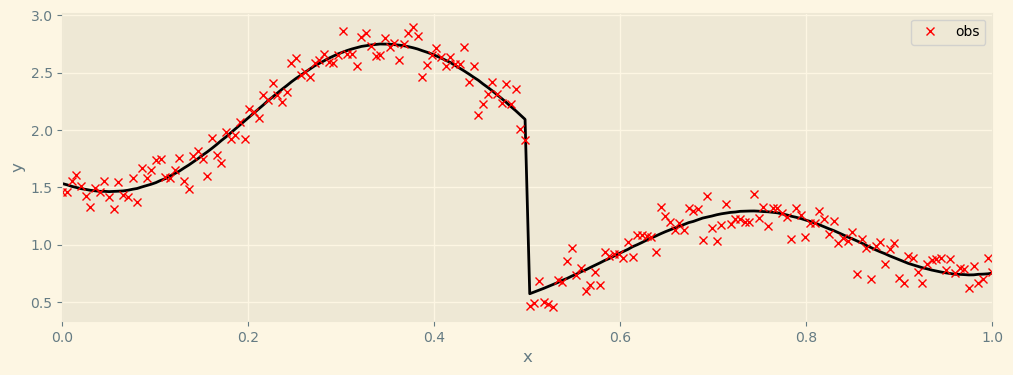

: 

In [11]:
'''DATASET 1'''
key = jrnd.PRNGKey(1234)

lengthscale_ = jnp.array([0.2, 1])
output_scale_ = jnp.array([2, 1])
period  = jnp.array([0.3, 0.1])
obs_noise_ = 0.1
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.5])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.Periodic()
kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        period = period,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    lengthscale=lengthscale_,
                    variance=output_scale_,
                    period = period,
                    obs_noise=obs_noise_)

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

In [5]:
def model_marginal(x, y, key):
    # %%time
    size = 20
    T = 1
    max_CP = size
    base_kernel = jk.Periodic()
    kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel)

    priors = dict(kernel=dict(lengthscale=LogNormal_mod(0, 3, max_CP+1),
                            variance=LogNormal_mod(0.5, 1, max_CP+1), 
                            period = LogNormal_mod(0, 3, max_CP+1),
                            num=Poisson_Process_hyper(size, T)
                                                                ),
                likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                    scale=1.),
                                                        tfb.Exp())),
                hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=1.,
                                                                scale=1.),
                                                        tfb.Exp())))

    gp_marginal = FullMarginalGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

    num_particles = 1000
    num_mcmc_steps = 100
    key, gpm_key = jrnd.split(key)
    mgp_particles, _, mgp_marginal_likelihood = gp_marginal.inference(gpm_key,
                                                                    mode='gibbs-in-smc',
                                                                    sampling_parameters=dict(num_particles=num_particles, num_mcmc_steps=num_mcmc_steps),
                                                                    poisson = True)
    return gp_marginal, mgp_particles

In [6]:
gp_marginal, mgp_particles = model_marginal(x, y, key)

No Gibbs kernel available, defaulting to Random Walk Metropolis MCMC, sigma = 0.01


Text(0, 0.5, 'period')

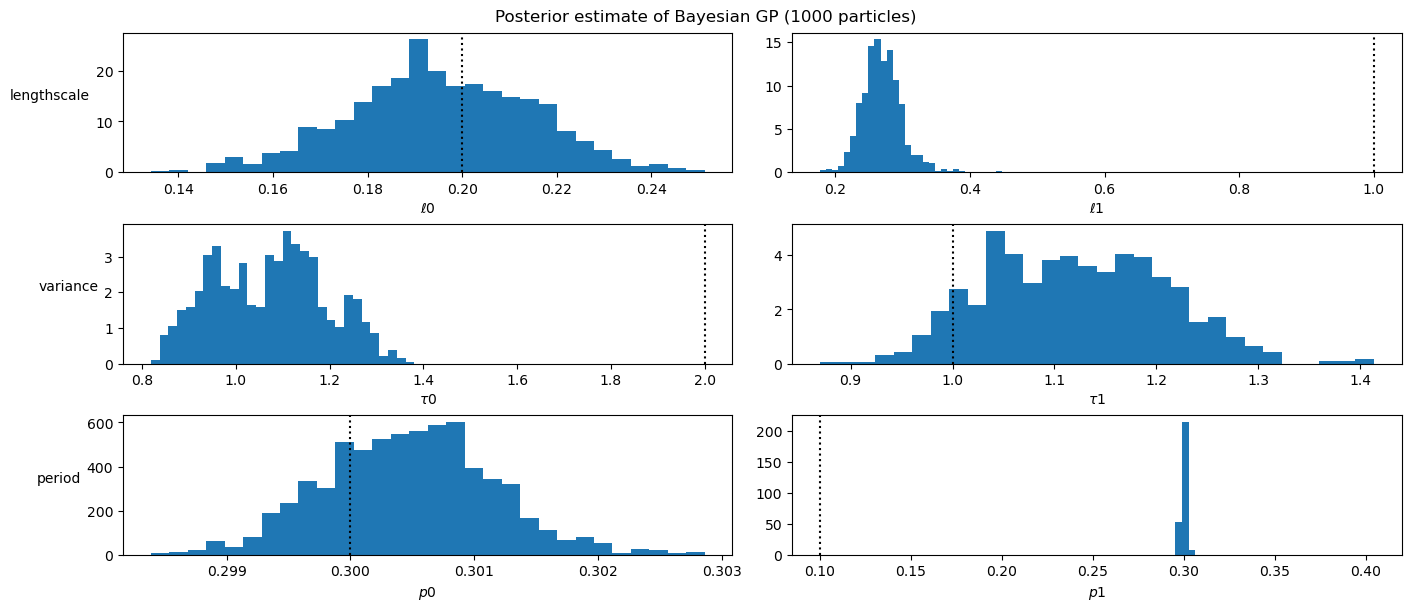

In [7]:
trainables = ['lengthscale', 'variance', 'period']

num_params = len(trainables)

symbols = dict( lengthscale='\ell',
                variance=r'\tau', 
                period = 'p')
max_CP = 1

_, axes = plt.subplots(nrows=num_params, ncols=max_CP+1, constrained_layout=True,
                    figsize=(14, 6))


# particles = mgp_particles
tr = dict(lengthscale=mgp_particles.particles['kernel']['lengthscale'],
            variance=mgp_particles.particles['kernel']['variance'],
            period = mgp_particles.particles['kernel']['period']
            )
            
for j, var in enumerate(trainables):
    pd = tr[var]
    # There are some outliers that skew the axes
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    for i in range(max_CP+1):
      axes[j, i].hist(pd[:, i], bins=30, density=True, color='tab:blue')
      axes[j, i].axvline(x=ground_truth[var][i], ls=':', c='k')

      if var in symbols:
          axes[j, i].set_xlabel(r'${:s}$'.format(symbols[var]+ str(i)))


num_particles = 1000
plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');

axes[0, 0].set_ylabel('lengthscale', rotation=0, ha='right')
axes[1, 0].set_ylabel('variance', rotation=0, ha='right')
axes[2, 0].set_ylabel('period', rotation=0, ha='right')

# plt.savefig(f"{savename}/{savename}_posteriors_periodic")

Text(0, 0.5, 'Marginal GP')

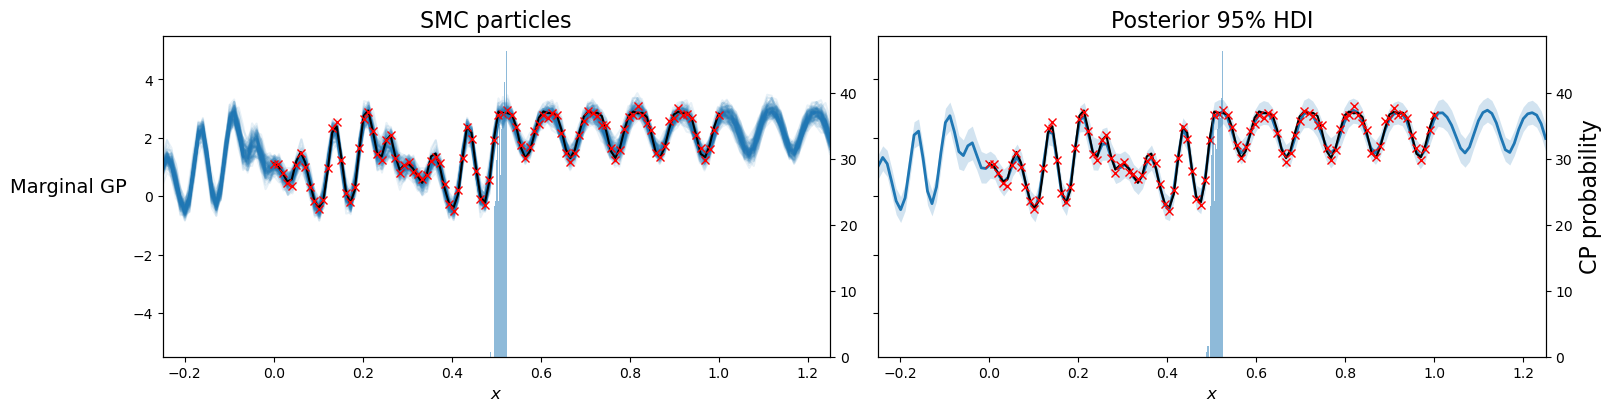

In [8]:
x_pred = jnp.linspace(-0.25, 1.25, num=150)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                            sharey=True, constrained_layout=True)


key, key_pred = jrnd.split(key)
f_pred = gp_marginal.predict_f(key_pred, x_pred)

pd = mgp_particles.particles['kernel']['num']
# There are some outliers that skew the axis
# pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
# pd_filtered = jnp.extract(pd>pd_l, pd)
# pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)

ax = axes[0]
for i in jnp.arange(0, num_particles, step=10):
    ax.plot(x_pred, f_pred[i, :], alpha=0.1, color='tab:blue')

new_pd = pd[jnp.logical_not(jnp.isnan(pd))]
ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)

ax = axes[1]
f_mean = jnp.mean(f_pred, axis=0)
y_pred = gp_marginal.predict_y(key_pred, x_pred)
f_hdi_lower = jnp.percentile(y_pred, q=2.5, axis=0)
f_hdi_upper = jnp.percentile(y_pred, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

ax.plot(x_pred, f_mean, color='tab:blue', lw=2)
ax.fill_between(x_pred, f_hdi_lower, f_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)

#print(new_pd.shape)

ax2 = ax.twinx()
ax2.hist(new_pd, bins=30, density=True, color='tab:blue', alpha=0.5)
ax2.set_ylabel('CP probability', fontsize=16)

for ax in axes.flatten():
    ax.plot(x, f_true, 'k', label=r'$f$')
    ax.plot(x, y, 'rx', label='obs')
    ax.set_xlim([-0.25, 1.25])
    ax.set_ylim([-5.5, 5.5])
    ax.set_xlabel(r'$x$', fontsize=12)

axes[0].set_title('SMC particles', fontsize=16)
axes[1].set_title('Posterior 95% HDI', fontsize=16)

axes[0].set_ylabel('Marginal GP', rotation=0, ha='right', fontsize=14)

Text(0, 0.5, 'Amount of particles')

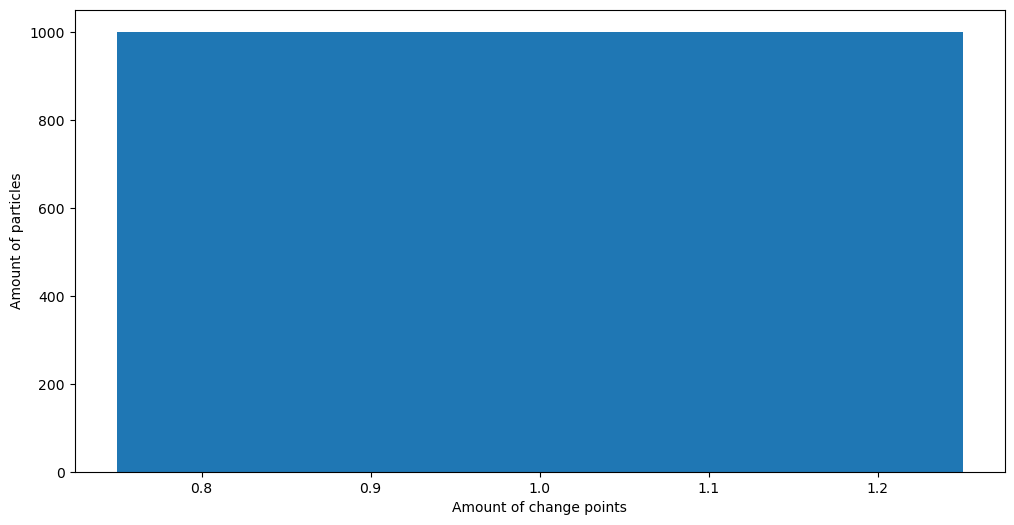

In [20]:
fig = plt.figure(figsize=(12, 6))
num_val = mgp_particles.particles['kernel']['num']
counts = jnp.count_nonzero(~jnp.isnan(num_val), axis = 1)
uni_vals = jnp.sort(jnp.concatenate([jnp.unique(counts)-0.5, jnp.unique(counts)+0.5]))
plt.hist(counts, bins=uni_vals, rwidth = 0.5)
plt.xlabel("Amount of change points")
plt.ylabel("Amount of particles")